In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from urllib.request import urlopen
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import re

In [2]:
def player_stats_by_year():

  all_players = []

  current_year = 1989
  end_year = 2020
  all_nba_team = all_nba()

  
  for year in range(current_year, end_year +1):
    # Load the yearly player stats
    url = "https://www.basketball-reference.com/leagues/NBA_{}_per_game.html".format(year)
    html = urlopen(url)
    soup = BeautifulSoup(html)
    # Find the statistics/column names
    columns = []
    for col in soup.find('tr').findAll('th'):
      columns.append(col.getText())
    columns.append("YEAR")
    columns.append("ALL-NBA")
    columns = columns [1:]


    # Find the player data for each column
    players = soup.findAll('tr')[1:]
    for player in range(len(players)):
      stats = []
      for stat in players[player].findAll('td'):
        stats.append(stat.getText())
      stats.append(year)
      # Players that are inducted in the hall of fame have an 
      # asterisks beside their names. We need to remove it to
      # properly match with the All NBA data.
      if str(stats[0])[-1] == "*":
        stats[0] = stats[0][:-1]
      # If player is in an All NBA team assign them a 1, 
      # otherwise a 0.
      if year in all_nba_team and stats[0] in all_nba_team[year]:
        stats.append(1)
      else:
        stats.append(0)
      all_players.append(stats)


  stats = pd.DataFrame(all_players, columns = columns)
  return stats

In [3]:
def all_nba():
  
  url = "https://www.basketball-reference.com/awards/all_league.html"
  html = urlopen(url)
  soup = BeautifulSoup(html)

  all_nba_by_year = {}
  start_year = 1988
  end_year = 2020
  counter = 0
  
  # Find every player 
  for row in soup.find_all('tr'):
    players = row.find_all('a')[2:]
    for player in players:
      player = player.getText()
      if counter == 15:
        end_year -= 1
        counter = 0
      if end_year >= start_year:
        if end_year in all_nba_by_year:
          all_nba_by_year[end_year].append(player)
        else:
          all_nba_by_year[end_year] = [player]
      counter += 1


  return  all_nba_by_year

## Data Preprocessing


Lets look at a few years of player data, to see what we are working with.

In [4]:
players_df = player_stats_by_year()

In [5]:
players_df.head()

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,YEAR,ALL-NBA
0,Kareem Abdul-Jabbar,C,41,LAL,74,74,22.9,4.2,8.9,.475,0.0,0.0,.000,4.2,8.9,.477,.475,1.6,2.2,.739,1.4,3.1,4.5,1.0,0.5,1.1,1.3,2.6,10.1,1989.0,0.0
1,Mark Acres,C,26,BOS,62,0,10.2,0.9,1.8,.482,0.0,0.0,1.000,0.9,1.8,.478,.487,0.4,0.8,.542,1.0,1.4,2.4,0.3,0.3,0.1,0.4,1.5,2.2,1989.0,0.0
2,Michael Adams,PG,26,DEN,77,77,36.2,6.1,14.1,.433,2.2,6.1,.356,3.9,8.0,.490,.509,4.2,5.1,.819,0.9,2.8,3.7,6.4,2.2,0.1,2.3,1.9,18.5,1989.0,0.0
3,Mark Aguirre,SF,29,TOT,80,76,32.5,7.3,15.9,.461,0.6,2.2,.293,6.7,13.7,.488,.481,3.6,4.9,.733,1.8,3.0,4.8,3.5,0.6,0.5,2.6,2.9,18.9,1989.0,0.0
4,Mark Aguirre,SF,29,DAL,44,44,34.8,8.5,18.8,.450,0.7,2.3,.293,7.8,16.6,.471,.467,4.0,5.5,.730,2.0,3.3,5.3,4.3,0.7,0.7,3.2,2.9,21.7,1989.0,0.0


In [6]:
print("The shape of the dataset is :", players_df.shape)

The shape of the dataset is : (18277, 31)


In [7]:
players_df.groupby(['YEAR']).agg(['sum'])['ALL-NBA']

,sum
YEAR,
1989.0,15.0
1990.0,15.0
1991.0,15.0
1992.0,15.0
1993.0,15.0
1994.0,17.0
1995.0,17.0
1996.0,15.0
1997.0,15.0


In [8]:
players_df.dtypes

Player      object
Pos         object
Age         object
Tm          object
G           object
GS          object
MP          object
FG          object
FGA         object
FG%         object
3P          object
3PA         object
3P%         object
2P          object
2PA         object
2P%         object
eFG%        object
FT          object
FTA         object
FT%         object
ORB         object
DRB         object
TRB         object
AST         object
STL         object
BLK         object
TOV         object
PF          object
PTS         object
YEAR       float64
ALL-NBA    float64
dtype: object

### Removing null values

In [9]:
players_df.isnull().sum()

Player       0
Pos          0
Age        699
Tm         699
G          699
GS         699
MP         699
FG         699
FGA        699
FG%        699
3P         699
3PA        699
3P%        699
2P         699
2PA        699
2P%        699
eFG%       699
FT         699
FTA        699
FT%        699
ORB        699
DRB        699
TRB        699
AST        699
STL        699
BLK        699
TOV        699
PF         699
PTS        699
YEAR       699
ALL-NBA    699
dtype: int64

In [10]:
players_df.dropna(axis=0, inplace=True)

### Removing duplicate values

Let's look at an example of a player who has been traded mid-season. 

In [11]:
players_df[(players_df["Player"] == 'Robert Covington') & (players_df["YEAR"] == 2019)]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,YEAR,ALL-NBA
17018,Robert Covington,SF,28,TOT,35,35,34.4,4.5,10.3,.431,2.4,6.4,.378,2.0,3.9,.518,.548,1.9,2.5,.764,0.8,4.7,5.5,1.3,2.1,1.3,1.3,3.6,13.3,2019.0,0.0
17019,Robert Covington,SF,28,PHI,13,13,33.8,3.8,9.0,.427,2.3,5.9,.390,1.5,3.1,.500,.556,1.3,1.8,.739,0.5,4.6,5.2,1.1,1.8,1.8,1.7,3.5,11.3,2019.0,0.0
17020,Robert Covington,SF,28,MIN,22,22,34.7,4.8,11.1,.433,2.5,6.7,.372,2.3,4.4,.526,.545,2.3,3.0,.773,1.0,4.8,5.7,1.5,2.3,1.1,1.1,3.7,14.5,2019.0,0.0


In [12]:
players_df.drop_duplicates(subset=['Player', 'YEAR'], keep='first', inplace=True)

If we run the query on that specific player again, we will only see one row.

In [13]:
players_df[(players_df["Player"] == 'Robert Covington') & (players_df["YEAR"] == 2019)]

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,YEAR,ALL-NBA
17018,Robert Covington,SF,28,TOT,35,35,34.4,4.5,10.3,.431,2.4,6.4,.378,2.0,3.9,.518,.548,1.9,2.5,.764,0.8,4.7,5.5,1.3,2.1,1.3,1.3,3.6,13.3,2019.0,0.0


### Changing player positions


In [14]:
players_df["Pos"].unique()

array(['C', 'PG', 'SF', 'PF', 'SG', 'SF-SG', 'PF-C', 'PF-SF', 'SG-SF',
       'PG-SG', 'SG-PG', 'SF-PF', 'C-PF', 'PG-SF', 'SG-PF', 'SF-C'],
      dtype=object)

Notice that player can be listed as having played in multiple positions. This can be attributed to the fact players switching teams mid-season may have a new role on the new team. The data lists the position played most first, so I will be using that as the main position. 

In [15]:
def main_position(position):

  if position.startswith('C'):
    return 'C'
  elif position == 'G':
    return 'PG'
  else:
    return position[:2]

players_df['Pos'] = players_df['Pos'].apply(main_position)

We can see if this worked by checking the unique values again.

In [16]:
players_df["Pos"].unique()

array(['C', 'PG', 'SF', 'PF', 'SG'], dtype=object)

If we were to one hot encode the positions, we would come up with an error. This is because we already have an existing column PF(personal fouls) with the position PF(power foward). So we can simply fix this by changing the personal fouls column name to "FOULS".

In [17]:
players_df.rename(columns={"PF": "FOULS"}, inplace=True )
one_hot = pd.get_dummies(players_df['Pos'])
players_df.drop('Pos', axis = 1, inplace=True)
players_df = players_df.join(one_hot)

In [18]:
players_df.drop(['Tm', 'Player', '3P%'], axis=1, inplace=True)

In [19]:
players_df = players_df.apply(pd.to_numeric)

In [20]:
players_df.dtypes

Age          int64
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
FOULS      float64
PTS        float64
YEAR       float64
ALL-NBA    float64
C            uint8
PF           uint8
PG           uint8
SF           uint8
SG           uint8
dtype: object

In [21]:
players_df = players_df[(players_df['G'] > 15) & (players_df['MP'] > 15)]

In [22]:
players_df.shape

(8957, 32)

## Exploratory Data Analysis

First lets take a look at each individual statistic's distribution.


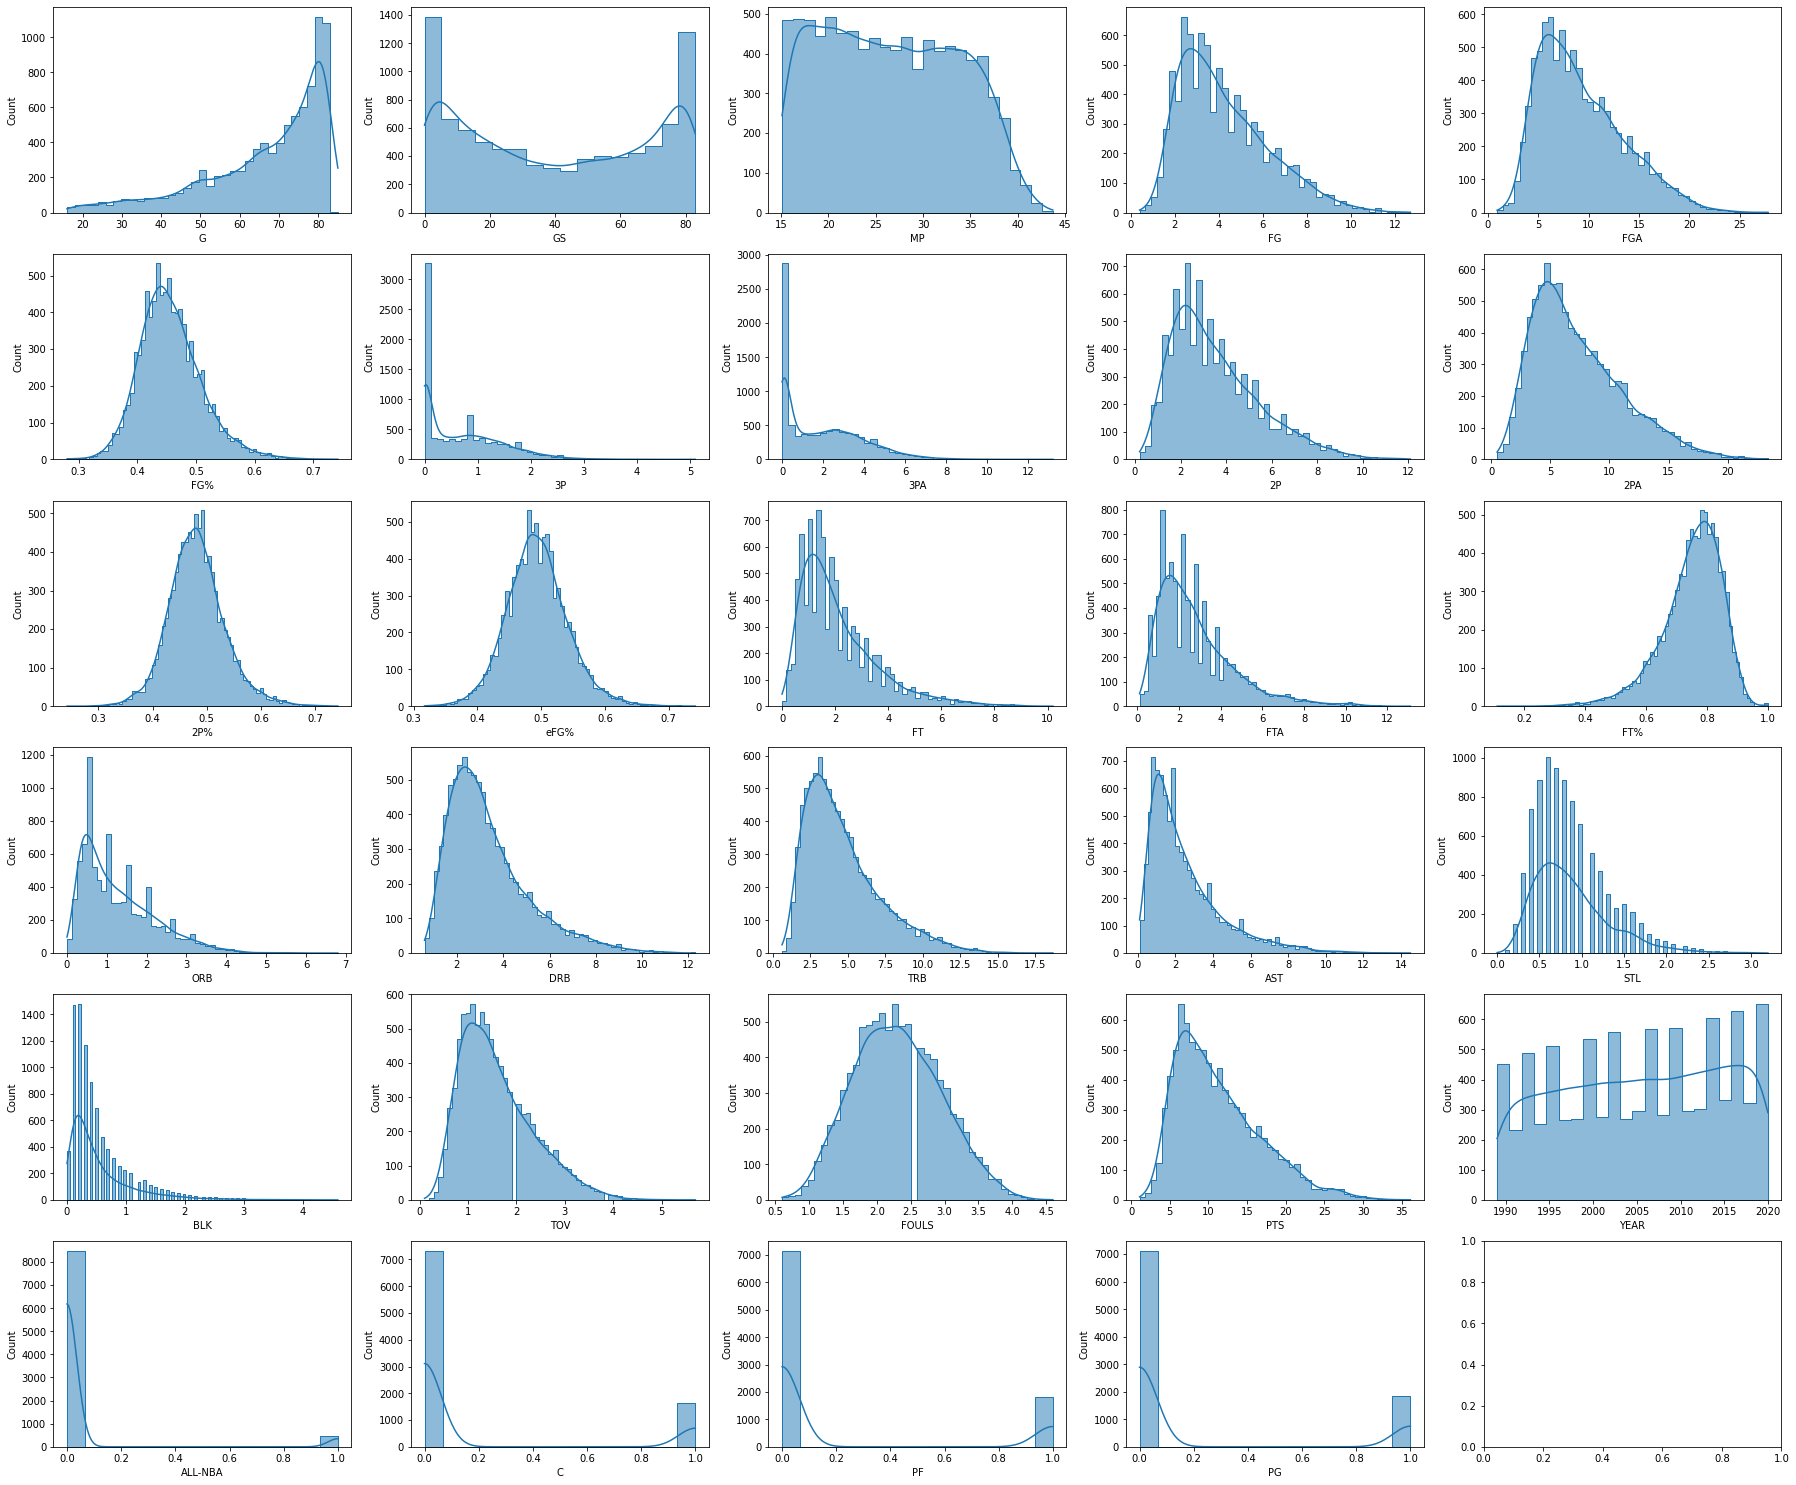

In [23]:
width = 5
height = 6

fig, ax = plt.subplots(height, width)
fig.subplots_adjust(bottom = 0, top = height - 1, 
                    left = 0, right = width - 1 )

columns = players_df.columns[1:30]

n = 0
m = 0
for col in columns:
  sns.histplot(players_df[col], kde=True, element="step", ax = ax[n][m])
  if m == width - 1:
    m = 0
    n += 1
  else:
    m += 1

Next, we can compare the boxplots of the statistics between all NBA and non all NBA players.



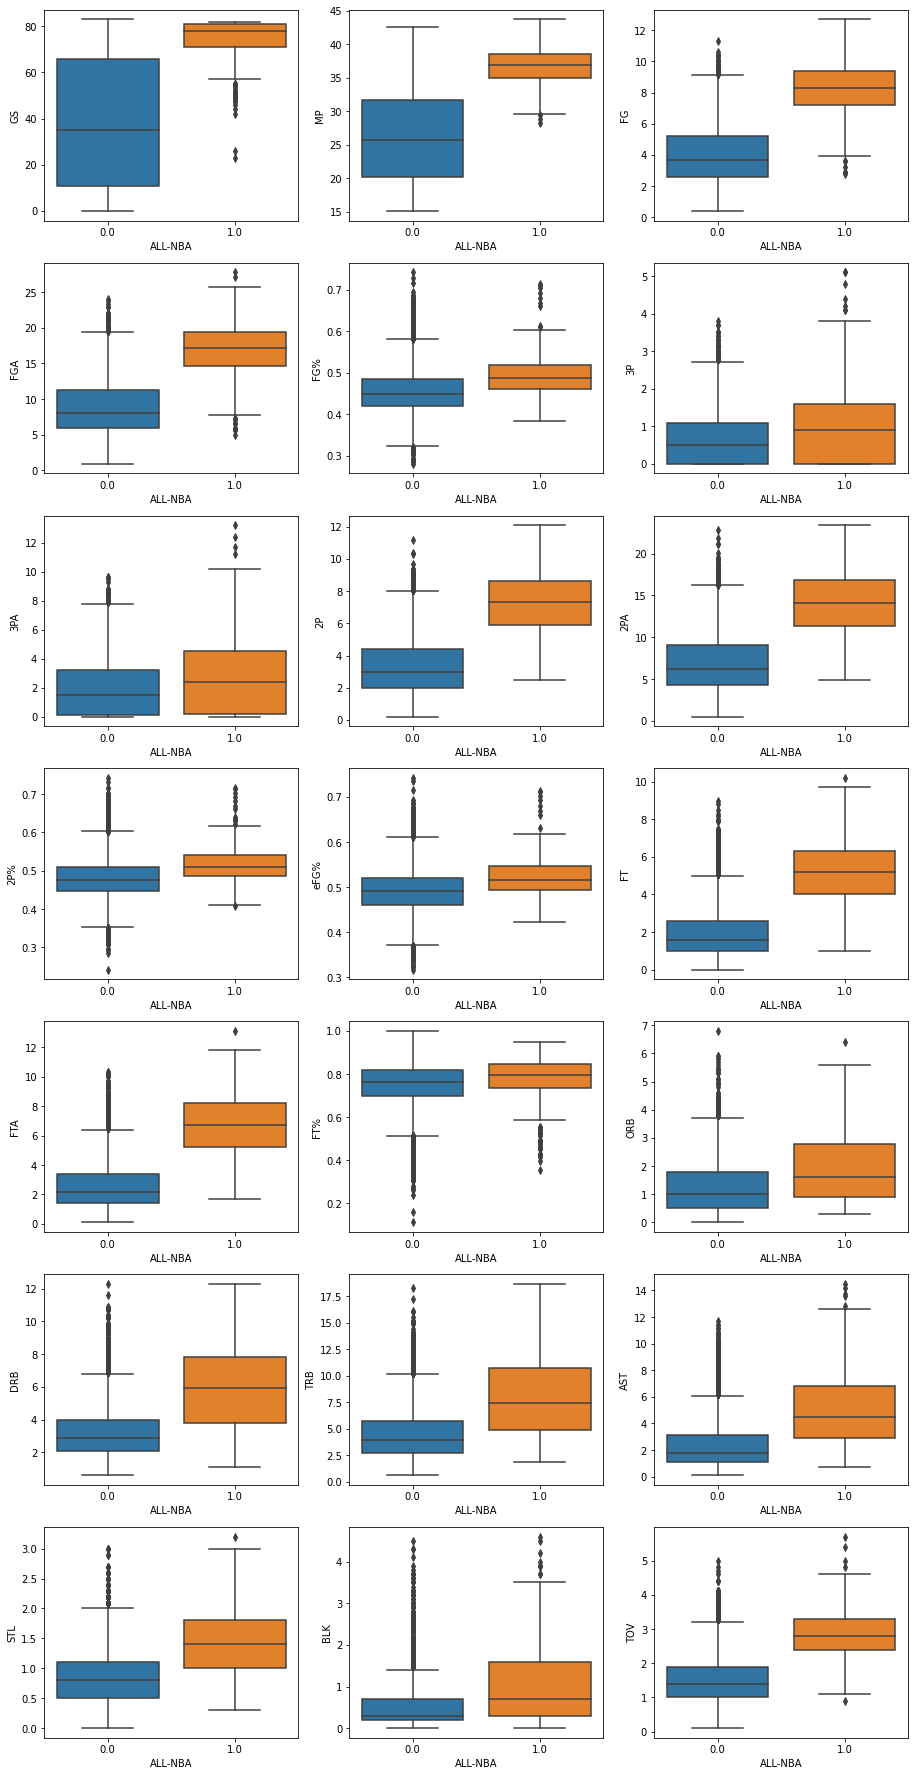

In [24]:
width = 3
height = 7

fig, ax = plt.subplots(height, width)
fig.subplots_adjust(bottom = 0, top = height - 1, 
                    left = 0, right = width - 1 )

columns = players_df.columns[2:23]

n = 0
m = 0
for col in columns:
  sns.boxplot(x="ALL-NBA", y = col, data=players_df, ax = ax[n][m])
  if m == width - 1:
    m = 0
    n += 1
  else:
    m += 1

Finally, we can check the correlation of each player statistic.

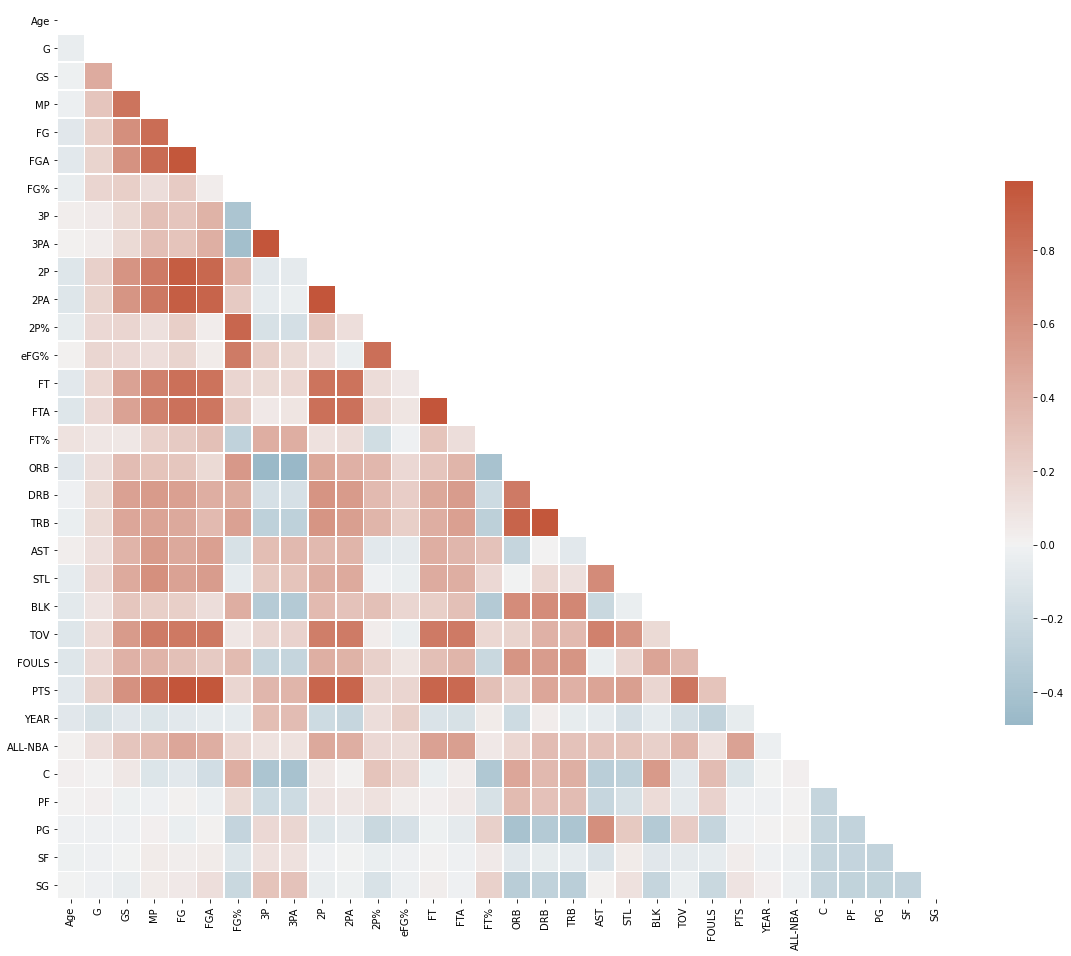

In [25]:
corr = players_df.corr()
fig, ax = plt.subplots(figsize=(20, 20))
mask = np.triu(np.ones_like(corr, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Creating train/test data
 

In [26]:
predictors = players_df.drop('ALL-NBA', axis=1, inplace=False)
outcome = players_df['ALL-NBA']
X_train, X_test, Y_train, Y_test = train_test_split(predictors, outcome, test_size = 0.3)

In [27]:
print("The shape of X train is :", X_train.shape)
print("The shape of X test is :", X_test.shape)
print("The shape of Y train is :", Y_train.shape)
print("The shape of Y test is :", Y_test.shape)

The shape of X train is : (6269, 31)
The shape of X test is : (2688, 31)
The shape of Y train is : (6269,)
The shape of Y test is : (2688,)


## Univariate logistic regression

In [28]:
def logistic_regression(col, weight=None):

  X_train, X_test, Y_train, Y_test = train_test_split(predictors, outcome, test_size = 0.3)

  if type(col) == str:
    X_test = X_test[col].values.reshape(-1, 1)
    X_train = X_train[col].values.reshape(-1, 1)
  else:
    X_test = X_test[col]
    X_train = X_train[col]

  model = LogisticRegression(class_weight = weight)
  model.fit(X_train, Y_train)

  predict = model.predict(X_test)
  accuracy = model.score(X_test, Y_test)
  roc = roc_auc_score(Y_test, predict)

  print("Accuracy: {}".format(accuracy))
  print("AUC-ROC: {}".format(roc))

  return model

In [29]:
logistic_regression('PTS', weight = 'balanced')

Accuracy: 0.8813244047619048
AUC-ROC: 0.9131361792365849


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
logistic_regression('STL', weight = 'balanced')

Accuracy: 0.7436755952380952
AUC-ROC: 0.7224464610973994


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [31]:
logistic_regression('FG%', weight = 'balanced')

Accuracy: 0.6770833333333334
AUC-ROC: 0.651730381643189


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
def plot_logistic(model1, col):

  low = np.min(players_df[col])
  high = np.max(players_df[col])

  nonallnbaavg = np.mean(players_df[players_df['ALL-NBA'] == 0][col])
  allnbaavg = np.mean(players_df[players_df['ALL-NBA'] == 1][col])

  x = np.linspace(low, high, 200)
  x_prob = np.reshape(x, (200, 1))
  y_prob = model1.predict_proba(x_prob)[:,1]

  plt.plot(x_prob, y_prob, color = 'black')
  plt.vlines(nonallnbaavg, ymin = 0, ymax = 1, color='blue', linestyles='dashed', label= 'non-All NBA')
  plt.vlines(allnbaavg, ymin = 0, ymax = 1, color='red', linestyles='dashed', label='All NBA')
  plt.title('Probability of making All NBA team, given {}'.format(col))
  plt.xlabel(col)
  plt.legend(title = 'Mean', loc='lower right' )


Accuracy: 0.8872767857142857
AUC-ROC: 0.8929491873088544


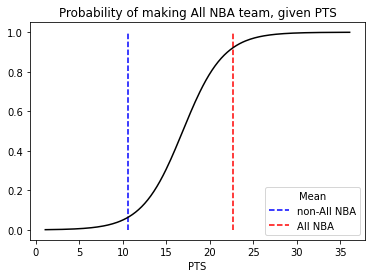

In [33]:
plot_logistic(logistic_regression('PTS', weight = 'balanced'), 'PTS')

Accuracy: 0.7366071428571429
AUC-ROC: 0.7112180834474623


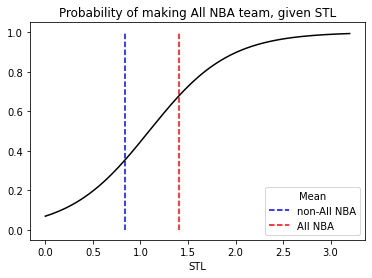

In [34]:
plot_logistic(logistic_regression('STL', weight = 'balanced'), 'STL')

Accuracy: 0.6789434523809523
AUC-ROC: 0.6930655778531394


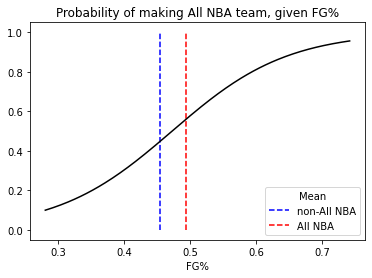

In [35]:
plot_logistic(logistic_regression('FG%', weight = 'balanced'), 'FG%')

## Multivariate logistic regression

In [36]:
def logistic_regression2(col, weight=None, scale=False):

  X_train, X_test, Y_train, Y_test = train_test_split(predictors, outcome, test_size = 0.3)

  if type(col) == str:
    X_test = X_test[col].values.reshape(-1, 1)
    X_train = X_train[col].values.reshape(-1, 1)
  else:
    X_test = X_test[col]
    X_train = X_train[col]
    if scale:
      scaler = MinMaxScaler()
      X_test = scaler.fit_transform(X_test)
      X_train = scaler.fit_transform(X_train)

  model = LogisticRegression(class_weight = weight, max_iter=5000)
  model.fit(X_train, Y_train)

  predict = model.predict(X_test)
  accuracy = accuracy_score(Y_test, predict)
  roc = roc_auc_score(Y_test, predict)


  print("Accuracy: {}".format(accuracy))
  print("AUC-ROC: {}".format(roc))

  return model

In [37]:
col = ['GS', 'MP', 'FG', 'FGA', '2P', '2PA', 'FT', 'FTA', 'DRB', 'TRB', 'AST', 'STL', 'PTS', 'TOV']
model = logistic_regression2(col, weight='balanced')

Accuracy: 0.9244791666666666
AUC-ROC: 0.9309331104659687


In [38]:
col2 = ['GS', 'MP', 'FGA', '2PA', 'FTA', 'TRB', 'AST', 'STL', 'PTS', 'TOV']
model2 = logistic_regression2(col2, weight='balanced')

Accuracy: 0.9229910714285714
AUC-ROC: 0.938849104859335


## Random forests

In [39]:
rf = RandomForestRegressor(random_state = 1)
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [40]:
predict = rf.predict(X_test)
acc = 1 - mean_squared_error(Y_test, predict)
roc = roc_auc_score(Y_test, predict)

print("MSE: {}".format(acc))
print("AUC-ROC: {}".format(roc))

MSE: 0.9743574404761904
AUC-ROC: 0.9715466195846696


Create grid search to find the best possible combinations of hyperparameters.

In [ ]:
n_estimators = [100, 500, 1000]
max_features = ['auto', 'log']
max_depth = [10, 20, 30]
min_samples_split = [10, 50, 100]
min_samples_leaf = [5, 10, 50]

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf,
              max_features = max_features)

gridF = GridSearchCV(rf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, Y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, max_features=20, min_samples_leaf=1, min_samples_split=2, random_state=2)
rf.fit(X_train, Y_train)


predict = rf.predict(X_test)
acc = 1 - mean_squared_error(Y_test, predict)
roc = roc_auc_score(Y_test, predict)

print("MSE: {}".format(acc))
print("AUC-ROC: {}".format(roc))
